# Entrenamiento del modelo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import sys
sys.path.append('..')  # Añade el directorio padre (logistic_regression) al path
from src.ft_functions import (softmax, compute_cost, gradient_descent_multinomial, 
                        predict)

### Leemos el DataSet de entrenamiento normalizado

In [2]:
# Para el entrenamiento solo necesitamos el Dataset train
df = pd.read_csv('../datasets/normal_train.csv')

## Variables del modelo

In [3]:
# 1. Crear la matriz y con todas las casas ya que estoy en un caso de clasificación multinomial
y = df[['House_Gryffindor', 'House_Hufflepuff', 'House_Ravenclaw', 'House_Slytherin']]

# 2. Seleccionar las características (X)
X = df[['Best Hand', 'Age', 'Herbology', 'Defense Against the Dark Arts',
        'Potions', 'Charms', 'Flying']]

# 3. Agregar columna de 1's para el término de sesgo (bias)
X = np.c_[np.ones(len(X)), X]

# Convertir a arrays de numpy para operaciones más eficientes
X = np.array(X)
y = np.array(y)

print("\nPrimeros 3 valores de X:")
print(X[:3])

print("\nPrimeros 3 valores de y:")
print(y[:3])


Primeros 3 valores de X:
[[ 1.          0.         -0.64873035  0.87996722  1.00749409 -0.69816049
   1.19974009 -0.4992794 ]
 [ 1.          1.         -0.32740279 -1.36481614  1.13059639  0.40759206
  -1.00452861 -1.38645949]
 [ 1.          0.         -0.36565607  1.26279717  0.77383265  0.88072797
   1.81945265  0.08810844]]

Primeros 3 valores de y:
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


## Función Sofmax

## Función de pérdida

In [4]:
# Inicializar pesos aleatoriamente
W = np.random.randn(X.shape[1], y.shape[1]) * 0.01

# Calcular coste inicial
cost = compute_cost(X, y, W)
print(f"Coste inicial: {cost}")

Coste inicial: 1.3918094405558008


## Entrenamiento del modelo

Para hacer predicciones con el modelo entrenado, podrías usar la función predict:

podemos ejecutarlo así:

In [5]:
# Hiperparámetros
learning_rate = 0.1
num_iterations = 5_000

# Ejecutar el descenso del gradiente multinomial
W_optimal, cost_history = gradient_descent_multinomial(X, y, learning_rate, num_iterations)

# Imprimir coste inicial y final
print(f"Coste inicial: {cost_history[0]}")
print(f"Coste final: {cost_history[-1]}")

# Hacer predicciones
probabilities = predict(X, W_optimal)

# Obtener la clase predicha
predicted_houses = np.argmax(probabilities, axis=1)
actual_houses = np.argmax(y, axis=1)
accuracy = np.mean(predicted_houses == actual_houses)
print(f"\nPrecisión del modelo: {accuracy:.4f}")

Iteración 0: Coste = 1.2860489201773462
Iteración 1000: Coste = 0.11881910311149532
Iteración 2000: Coste = 0.11451218653424569
Iteración 3000: Coste = 0.11245786670877131
Iteración 4000: Coste = 0.11118248885457539
Coste inicial: 1.3765547701856666
Coste final: 0.1102672322399086

Precisión del modelo: 0.9831


## Visualización de la evolución del coste

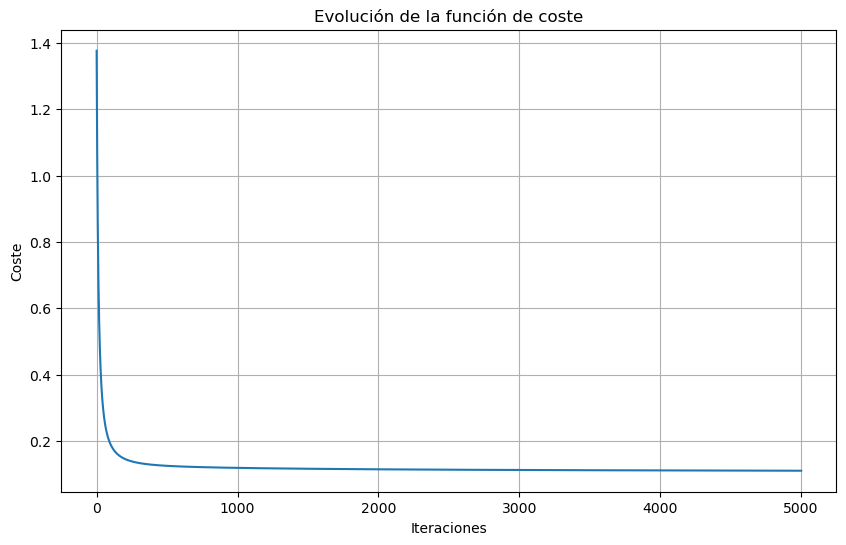

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(cost_history)
plt.title('Evolución de la función de coste')
plt.xlabel('Iteraciones')
plt.ylabel('Coste')
plt.grid(True)
plt.show()

## Visualizar pesos para cada característica

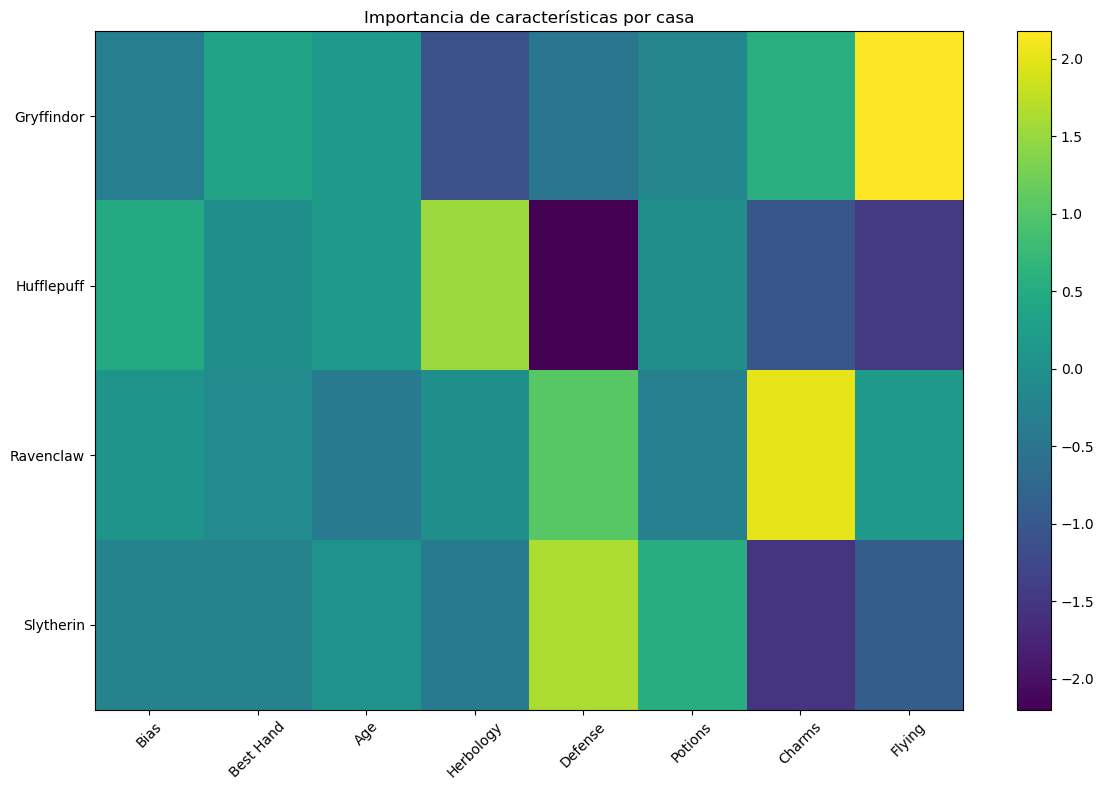

In [7]:
# visualiza la importancia de las diferentes características (features)
feature_names = ['Bias', 'Best Hand', 'Age', 'Herbology', 'Defense', 'Potions', 'Charms', 'Flying']
house_names = ['Gryffindor', 'Hufflepuff', 'Ravenclaw', 'Slytherin']

plt.figure(figsize=(12, 8))
plt.imshow(W_optimal.T, aspect='auto')
plt.colorbar()
plt.xticks(range(len(feature_names)), feature_names, rotation=45)
plt.yticks(range(len(house_names)), house_names)
plt.title('Importancia de características por casa')
plt.tight_layout()
plt.show()

## Grabación de los pesos óptimos

In [8]:
def save_weights(W, output_file='../output/model_weights.json'):
    """
    Guarda los pesos del modelo en formato JSON
    
    Parámetros:
    W: matriz de pesos numpy del modelo
    output_dir: directorio donde guardar el archivo
    """    
    # Convertir matriz de pesos numpy a lista
    weights = W.tolist()
    
    # Guardar en JSON
    with open(output_file, 'w') as f:
        json.dump(weights, f)




### Guardar pesos óptimos
Después del entrenamiento

In [9]:
# Ejecuta la función
save_weights(W_optimal)